In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

print('Using tensorflow version:', tf.__version__)

Using tensorflow version: 2.5.0


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [3]:
dtw = pd.read_csv('torem_dtw.csv')
rating = pd.read_csv('ratings.csv')

In [6]:
dtw.loc[dtw['Google Review'].isna(), 'Google Review'] = 4.4
# dtw[dtw['Google Review'].isna()]
dtw.head()

,ID,Nama Daya Tarik Wisata,Alamat,Daerah,Provinsi,Kawasan,Kategori,Google Review,Google Map ID
0,1,Pantai Kuta,"Kuta, Badung, Bali",Kuta,Bali,Pantai,Alam,4.4,ChIJkbJrRYFH0i0RggJb7CncdHE
1,2,Peninsula Island,"Pulau Peninsula Nusa Dua, Nusa Dua, Benoa, Kec...",Nusa Dua,Bali,Pantai,Alam,4.5,ChIJM51wq9dC0i0RktOawQYW3jk
2,3,Pura Luhur Uluwatu,"Pecatu, Kec. Kuta Sel., Kabupaten Badung, Bali",Pecatu,Bali,Pantai,Budaya,4.6,ChIJkYHLIPxP0i0RlQTbpxuNuQw
3,4,Garuda Wisnu Kencana,"Jl. Raya Uluwatu, Ungasan, Kuta Selatan Badung...",Ungasan,Bali,Kota,Monumen,4.5,ChIJx97hVM9E0i0RUVpPBj5miBk
4,5,Pantai Padang - Padang,"Pecatu, Kuta Selatan, Kabupaten Badung, Bali.",Pecatu,Bali,Pantai,Alam,4.4,ChIJV-JMXVBF0i0RFUBMWOw7eGQ


In [5]:
rating.head()

,user_id,dtw_id,rating
0,1,84,4.8
1,1,96,4.5
2,2,98,3.3
3,2,73,4.3
4,2,35,4.3


In [13]:
user_num = rating['user_id'].nunique()
dtw_num = rating['dtw_id'].nunique()

In [19]:
# dtw_num
# user_num
rating.shape

(1243, 3)

In [44]:
def RecommenderV2(n_users, n_dtws):
    
    # User
    user = Input(shape=[1])
    U = Embedding(n_users+1,15)(user)
    U = Flatten()(U)
    
    # dtw
    dtw = Input(shape=[1])
    M = Embedding(n_dtws+1,15)(dtw)
    M = Flatten()(M)
    
    # Gabungkan disini
    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dropout = Dropout(0.5)(dense_1)
    final = Dense(1)(dropout)
    
    model = Model(inputs=[user, dtw], outputs=final)
    
    model.compile(optimizer=Adam(0.001),
                  loss='mean_squared_error')
    
    return model

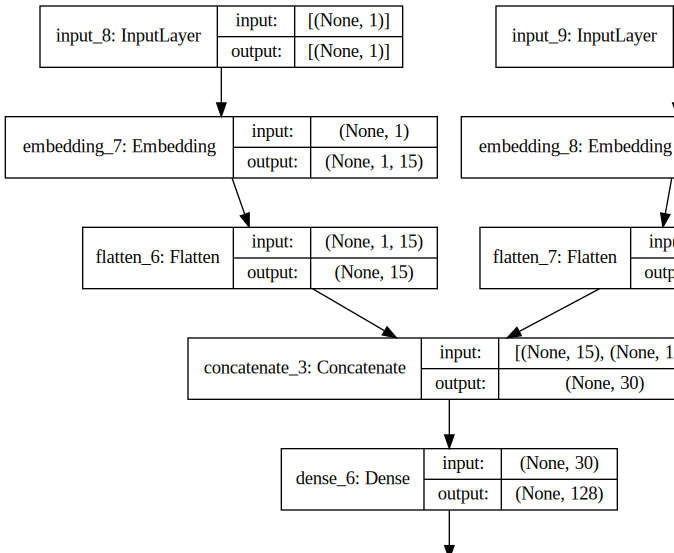

In [45]:
model = RecommenderV2(user_num, dtw_num)

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [46]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 15)        3015        input_8[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 15)        1605        input_9[0][0]                    
____________________________________________________________________________________________

In [17]:
from sklearn.model_selection import train_test_split

X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.1,
                                                  stratify=y,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1118, 2), (125, 2), (1118,), (125,))

In [47]:
# y.head()
X.head()

,user_id,dtw_id
0,1,84
1,1,96
2,2,98
3,2,73
4,2,35


In [48]:
checkpoint = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [49]:
history = model.fit(x=[X_train['user_id'], X_train['dtw_id']],
                    y=y_train,
                    batch_size=5,
                    epochs=6,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['dtw_id']], y_val),
                    callbacks=[checkpoint]
                    )

Epoch 1/6
224/224 [==============================] - 2s 5ms/step - loss: 6.2413 - val_loss: 0.4327
Epoch 2/6
224/224 [==============================] - 1s 4ms/step - loss: 0.5843 - val_loss: 0.4100
Epoch 3/6
224/224 [==============================] - 1s 4ms/step - loss: 0.5820 - val_loss: 0.4175
Epoch 4/6
224/224 [==============================] - 1s 4ms/step - loss: 0.5276 - val_loss: 0.4052
Epoch 5/6
224/224 [==============================] - 1s 4ms/step - loss: 0.5354 - val_loss: 0.4352
Epoch 6/6
224/224 [==============================] - 1s 4ms/step - loss: 0.5092 - val_loss: 0.4113


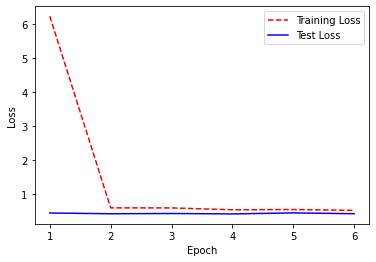

In [50]:
# Get training and test loss histories
training_loss2 = history.history['loss']
test_loss2 = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [51]:
from tensorflow.keras.models import load_model

model = load_model('model1.h5')

In [52]:
def make_pred(user_id, dtw_id, model):
    return model.predict([np.array([user_id]), np.array([dtw_id])])[0][0]

In [72]:
def get_topN_rec(user_id, model):
    
    user_id = int(user_id) - 1
    user_ratings = rating[rating['user_id'] == user_id]
    recommendation = rating[~rating['dtw_id'].isin(user_ratings['dtw_id'])][['dtw_id']].drop_duplicates()
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(user_id, x['dtw_id'], model), axis=1)
    
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(dtw_new[['dtw_id', 'name']],
                                                                                       on='dtw_id').head(10)
    
    return final_rec.sort_values('rating_predict', ascending=False)[['name', 'rating_predict']]

In [57]:
user_ratings = rating[rating['user_id'] == 24]
user_ratings

,user_id,dtw_id,rating
152,24,35,3.4
153,24,33,3.7
154,24,19,3.5
155,24,69,4.5
156,24,48,4.0
157,24,77,3.1
158,24,45,4.3
159,24,26,3.5
160,24,20,3.6


In [60]:
recommendation = rating[~rating['dtw_id'].isin(user_ratings['dtw_id'])][['dtw_id']].drop_duplicates()
# ~rating['dtw_id'].isin(user_ratings['dtw_id'])

In [73]:
get_topN_rec(23, model)

,name,rating_predict
0,Ciputih Resort Ujung Kulon,4.850907
1,Taman Nasional Ujung Kulon,4.552100
2,Pulau Sangiang,4.443357
3,Kebun Teh Wonosari,4.244282
4,Museum Angkut Malang,4.227908
5,Air Terjun Sri Gethuk,4.218156
6,Air Terjun Oenesu,4.216429
7,Taman Nasional Komodo,4.208915
8,HeHa Sky View,4.205467
9,Museum Manusia Purba Klaster Ngebung,4.185772


In [70]:
dtw_new = dtw.rename(columns={'ID': 'dtw_id'})
dtw_new = dtw_new.rename(columns={'Nama Daya Tarik Wisata': 'name'})
dtw_new.head()

,dtw_id,name,Alamat,Daerah,Provinsi,Kawasan,Kategori,Google Review,Google Map ID
0,1,Pantai Kuta,"Kuta, Badung, Bali",Kuta,Bali,Pantai,Alam,4.4,ChIJkbJrRYFH0i0RggJb7CncdHE
1,2,Peninsula Island,"Pulau Peninsula Nusa Dua, Nusa Dua, Benoa, Kec...",Nusa Dua,Bali,Pantai,Alam,4.5,ChIJM51wq9dC0i0RktOawQYW3jk
2,3,Pura Luhur Uluwatu,"Pecatu, Kec. Kuta Sel., Kabupaten Badung, Bali",Pecatu,Bali,Pantai,Budaya,4.6,ChIJkYHLIPxP0i0RlQTbpxuNuQw
3,4,Garuda Wisnu Kencana,"Jl. Raya Uluwatu, Ungasan, Kuta Selatan Badung...",Ungasan,Bali,Kota,Monumen,4.5,ChIJx97hVM9E0i0RUVpPBj5miBk
4,5,Pantai Padang - Padang,"Pecatu, Kuta Selatan, Kabupaten Badung, Bali.",Pecatu,Bali,Pantai,Alam,4.4,ChIJV-JMXVBF0i0RFUBMWOw7eGQ


In [74]:
export_dir = 'model'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model/assets


In [75]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
# converter.optimizations = [tff.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [76]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [78]:
from google.colab import files
# files.download("model.zip")
files.download('model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>